- **TODO:** code the telemtry data to have the proper wedge values. 
- **TODO:** minute markers spaces should have a 2px 11 or 244 (whichever is inverted from the backgroud) line in them every minute
- **TODO:** implement carrier detection/deal with doppler dritf


# APT digital signal processing

- source: [NOAA KLM user's guide, Section 4.2: APT System](www.ncdc.noaa.gov/oa/pod-guide/ncdc/docs/klm/html/c4/sec4-2.htm)
- The Engineers and Scientists guide to digital signal processing

This notebook implements functions for generating APT data signals and modulated APT baseband 2.4 kHz subcarrier signals eg. for the purpose of testing image decoding software. The file [/signal-processing/APT-decoder.grc](./signal-processing/APT-decoder.grc) in this repository is a GNURadioCompanion flow chart that implements a somewhat naïve but functioning APT image decoder. 

## Image decoding algorithm

The baseband signal that is received from a satellite's FM broadcast consists of a 8-bit pulse code modulated (PCM) image data and metadata signal that has been amplitude modulated to a 2.4 kHz subcarrier. The symbol rate of the PCM signal is  4160 symbols/second



![grc flow chart of the image decoder](APT-decoder.grc.png)


### Band pass filter

The cutoff frequency of the bandpass filter is set to 4200 Hz, in order to include the fundamental 4160 Hz frequency of the PCM coded data, and the 2400 Hz subcarrier.

### Subcarrier demodulation

The first step in the AM demodulator is to resample the filtered baseband signal at 4 times the subcarrier frequency: 2400 × 4 = 9600 samples/second. This gives a new representation of the signal where each period of the subcarrier is sampled at 90° phase intervals.

The momentary amplitude $A$ of a sine wave can be calculated given two samples $s_1$ and $s_2$ that have a 90° phase difference compared to eachother.  

$$A = \sqrt{s_1^2 + s_2^2} $$

The calculation is essentialy the pythagorean theorem, and is implemented in the GRC flow chart as the magnitude of a coplex vector. The imaginary and real components of the vector are the $s_1$ and $s_2$ values respectively

### Post demodulation

Demodulation of the subcarrier produces a 9600 samples/second stream of the image data, represented using floating point values in the range $\{0...1\}$. The stream is resampled at the data symbol rate: 4160 samples/second, in order to represent each data symbol with a single sample. The final samples are multiplied by 255, cast to 8-bit usigned integers, and written to a file in sequence.

Each byte in the written file prepresents a single pixel value. The file is converted to a .png using the `convert` utility from ImageMagick. A line in APT is 2080 pixels wide.

```
convert -size 2080x1500 -depth 8 test.wav.gray test.wav.png
```

# Test image generation

In [20]:
# this line makes the plots visilble in the jupyter notebook
%matplotlib inline

from __future__ import division
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import math
import random

"""
mul is a global variable that is used in the
generator functions in order to produce the correct
amout of data. Mul should be an interger value.

The final sample rate of the data is 2080 * mul

Considering that the data will be modulated with a 
"""
mul = 1

def syncA():
    data = mul*4*[11]
    # 7 1040 Hz 50% duty pulses
    for i in xrange(0,7):
        data += mul*2 * [244]
        data += mul*2*[11]
    data += mul*7 * [11]
    return data

def syncB():
    data = mul*4*[11]
    # 7  832 Hz 3/5 duty pulses
    for i in xrange(0,7):
        data += mul*3 * [244]
        data += mul*2*[11]
    return data

def markerA():
    return mul*47 * [11]
def markerB():
    return mul*47 * [244]


def videoA():
    """
    Note that since here are only 244-11=233 pixel values
    avilable, the quantisized gradient will have
    multiple consicutive pixels with the same value
    """
    data = 0*[0]
    for i in range(0,909):
        # dont use all of the dynamic range (-50)
        data += [int((i*(244-11))/(909) + 11)] * mul
    return data
def videoB():
    """fills B channel with random data"""
    data = 0*[0]
    for i in range(0,909):
        data += [random.randint(11,244)] * mul
    return data

""" These still need some work: implement wedges"""
def telemetryA(value=128):
    return mul*45 * [value]
def telemetryB(value=128):
    return mul*45 * [value]


def line(telemetry=128):
    """organize all the parts of a line in the right order"""
    data = syncA()
    data += markerA()
    data += videoA()
    data += telemetryA(value=telemetry)
    data += syncB()
    data += markerB()
    data += videoB()
    data += telemetryB(value=telemetry)
    return data

def frame():
    """an APT frame is 128 lines high"""
    data = [0]*0
    
    # these have calimbration wedges
    for i in xrange(0,8): 
        for j in range(0,8):          
            data += line(telemetry=int(11 + (233/7) * i))
    # these have actual telemetry
    for i in xrange(0,64):
        data += line()
    return data

This next part show an example of how to use the
APT functions in a way that will work well with 
DSP techniques, and plot some visualizations of
what APT data looks like

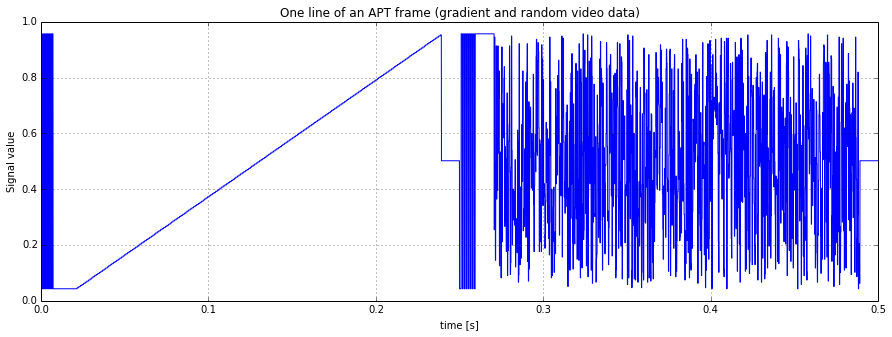

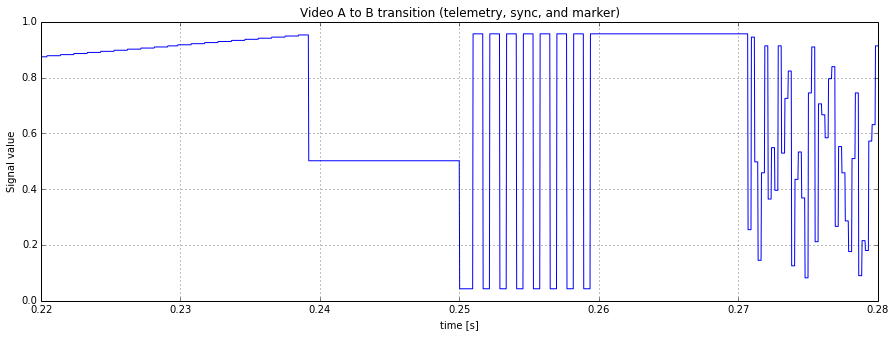

In [24]:

# make sure we will have plenty of samples
mul = 8
# convert from int space 0...256 to float space 0 ... 1.0
data = line()
data = [val /255 for val in data]

# plot agains eiher symbol index, or actual time
# idx =  np.linspace(0,len(data) -1 ,len(data))
time = np.linspace(0,0.5,len(data))

plt.figure(figsize=(15,5))
plt.grid()
plt.title("One line of an APT frame (gradient and random video data)")
plt.ylim(0, 1)
plt.xlabel("time [s]")
plt.ylabel("Signal value")
plt.plot(time, data)

plt.figure(figsize=(15,5))
plt.grid()
plt.title("Video A to B transition (telemetry, sync, and marker)")
plt.ylim(0, 1)
plt.xlim(0.22, 0.28)
plt.xlabel("time [s]")
plt.ylabel("Signal value")
plt.plot(time, data)

plt.show()


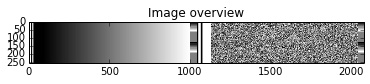

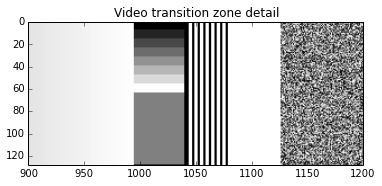

In [22]:
# data signal for creating a bitmap
mul = 1
image_data = np.reshape(frame()+frame(), (-1, 2080))

plt.figure()
plt.imshow(image_data, cmap="gray")
plt.title("Image overview")
plt.figure()
plt.title("Video transition zone detail")
plt.xlim(900,1200)
plt.ylim(128, 0)
plt.imshow(image_data, cmap="gray")
plt.show()

## Generating test audio

The code block below generates a .wav file in with one frame (128 lines) of APT image data modulated to the 2.4 kHz baseband subcarrier.

In [4]:
from scipy.io.wavfile import write

# make sure we will have plenty of samples
mul = 10
data = frame()
# convert from int space 0...256 to float space 0 ... 1.0
data = [val/255 for val in data]

# time axsis with actual seconds as unit
elapsed_time = len(data) / mul / 4160
time = np.linspace(0,elapsed_time,len(data))

# multiply data with 2400 Hz sine wave
modulated = np.multiply(np.sin([2*np.pi*2400*val for val in time]), data)

# wxtoimg wants uint16 samples
scaled = np.int16(modulated/np.max(np.abs(modulated)) * 32767)

# two lines a second, 2080 symbols per line, mul samples per symbol
write("/tmp/test.wav", 2*2080*mul, scaled)

# Strangeness

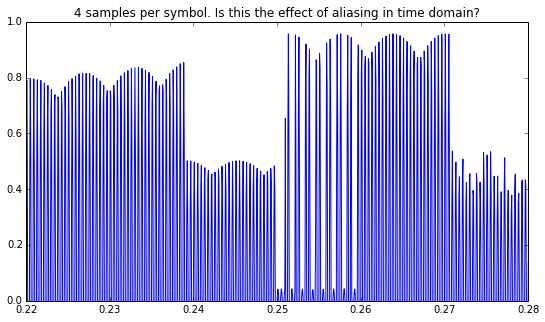

In [16]:

mul = 4
data = [val/255 for val in line()]
time = np.linspace(0,len(data) / mul / 4160,len(data))
modulated = np.multiply(np.sin([2*np.pi*2400*val for val in time]), data)

plt.figure(figsize=(9,5))
plt.title("4 samples per symbol. Is this the effect of aliasing in time domain?")
plt.ylim(0, 1)
plt.xlim(0.22, 0.28)
plt.plot(time, modulated)

plt.show()